# Nonlinear TPBVP

Now consider the nonlinear TPBVP

$$
F(x,u,u',u'') &= 0, \quad a < x < b, \\ 
g_a(u(a),u'(a))  &= 0, \\ 
g_b(u(b),u'(b))  &= 0.
$$

Our approach to discretization remains the same. We choose nodes $x_0,\ldots,x_n$, replace $u(x)$ by a vector of its values at the nodes, and use FD formulas when derivatives of $u$ are called for. However, the result is a nonlinear system of algebraic equations

$$
\bff(\bfu) = \bfzero.
$$

Using a black-box nonlinear equation solver, it's rather easy to get solutions. For example, here is a solution of 

$$
\lambda u'' + u(u'-1) = -x, \quad u(0)=-1, \quad u(1)=1. 
$$

In [1]:
include("diffmats.jl")
using NLsolve
function bvp(λ,n)
  a,b = 0,1
  h = (b-a)/n
  x = [a+i*h for i in 0:n]
  Dx,Dxx = diffmats(x)
  ode = u -> λ*Dxx*u + u.*(Dx*u .- 1) + x
  residual = u -> [ode(u)[2:n];u[1]+1;u[n+1]-1]
  u = nlsolve(residual,zeros(n+1))
  return x,u.zero
end

bvp (generic function with 1 method)

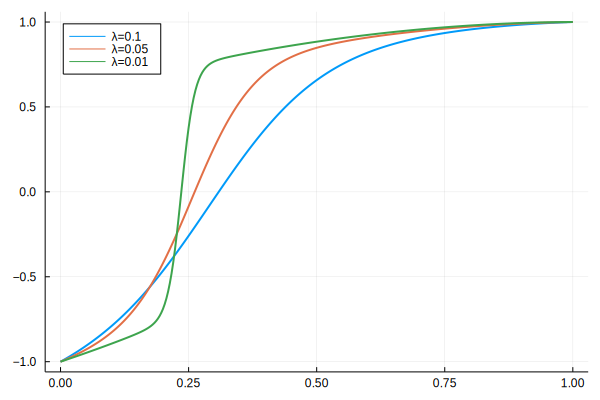

In [2]:
using Plots
plt = plot(legend=:topleft)
for λ in [0.1,0.05,0.01]
    x,u = bvp(λ,300);
    plot!(x,u,label="λ=$λ")
end
plt

The standard approach is to use a Newton-style method in which we replace the nonlinear problem by a sequence of linear surrogates that we construct and solve iteratively, i.e,

$$
\bfA_k \bfs_k &= \bff(\bfu_k),\\
\bfu_{k+1} &= \bfu_k - \bfs_k,
$$

where $\bfA_k$ is an approximation to the **Jacobian matrix**

$$
\bfJ(\bfu_k) = \left. \begin{bmatrix}
  \pp{f_i}{u_j}
\end{bmatrix} \right\lvert_{\bfu=\bfu_k}. 
$$

Good performance in the nonlinear solver boils down mainly to two factors: an efficient and sufficiently accurate way to produce/apply $\bfA_k$, and selection of the initial estimate $\bfu_0$.

## Jacobian matrix

There are essentially three possibilities worth pursuing when the system size is $\approx O(1000)$ or less. 

### Exact Jacobian

Using the exact Jacobian matrix ensures the fastest possible convergence of the solver iterations. However, it can take significant human effort to put this into practice.

For example, consider solving the ODE

$$
u'' + u u' - 1 = 0,
$$

subject to Dirichlet boundary conditions at $x=0$ and $x=1$. 

With our usual approach, a discrete version of the equation is $\bff(\bfu)=\bfzero$, where

$$
\bff(\bfu) = \bfD_{xx}\bfu + \bfu \odot (\bfD_x \bfu) - \boldsymbol{1},
$$

using the **Hadamard product** (elementwise) $\odot$. Suppose we want to linearize $\bff$ about the given vector $\bfu_k$. Perturbing to $\bfu_k + \epsilon \bfv$, we have 

$$
\bff(\bfu_k+\epsilon \bfv) & = \bfD_{xx}(\bfu_k+\epsilon \bfv) + (\bfu_k+\epsilon \bfv) \odot [\bfD_x (\bfu_k+\epsilon \bfv)] - \boldsymbol{1}\\ 
&= \underbrace{\bfD_{xx} \bfu_k+ + \bfu_k \odot (\bfD_x \bfu_k) - \boldsymbol{1}}{} + \epsilon [\bfD_{xx}\bfv + \bfv \odot (\bfD_x \bfu_k) + \bfu_k \odot (\bfD_x \bfv)  ]  + O(\epsilon^2). 
$$

The $O(\epsilon)$ term represents the action of the Jacobian on the perturbation. Hence,

$$
\bfJ = \bfD_{xx}+ \diag(\bfD_x \bfu_k) + \diag(\bfu_k) \bfD_x.
$$

(Note that the result, like any derivative, depends on the evaluation "point" $\bfu_k$.) 

That's just for the ODE. If there are linear boundary conditions on $u(x)$, then the same conditions hold *homogeneously* for $v$. If we replace the first and last rows of $\bff$ with discrete BC operators, then we also replace the first and last rows of $\bfJ$. 
If we use fictitious points, the Schur complement trick can be applied to $\bfJ$, although it may be simpler to simply leave the fictitious points in the discrete system.

In [3]:
using LinearAlgebra

include("diffmats.jl")
n = 200
h = (1-0)/n
x = [i*h for i in 0:n]
Dx,Dxx = diffmats(x)

function residual(u) 
    r = Dxx*u + 0*u.*(Dx*u) .- 1
    r[1] = (-1.5u[1]+2u[2]-0.5u[3])/h
    r[n+1] = u[n+1]-2
    return r
end;

function jac(u)
    ux,uxx = Dx*u,Dxx*u
    J = Dxx + 0*diagm(ux) + 0*diagm(u)*Dx
    # Neumann on left, Dirichlet on right 
    J[1,:] .= [-1.5/h;2/h;-0.5/h;zeros(n-2)]
    J[n+1,:] .= [zeros(n);1]
    return J
end;

It's advisable to check your Jacobian to see if it does the correct thing on at least one generic input. Remember as you set up the data that $u$ and $v$ are expected to obey certain boundary conditions.

In [4]:
u = x.^2 .+ 1
v = cos.(π*x/2)
ϵ = 1e-5
du = (residual(u+ϵ*v) - residual(u))/ϵ
Jv = jac(u)*v
norm(du-Jv)

1.1880164375390433e-5

We don't have to make sure that the initial guess satisfies the boundary conditions, because a single Newton iteration will take care of that for us.

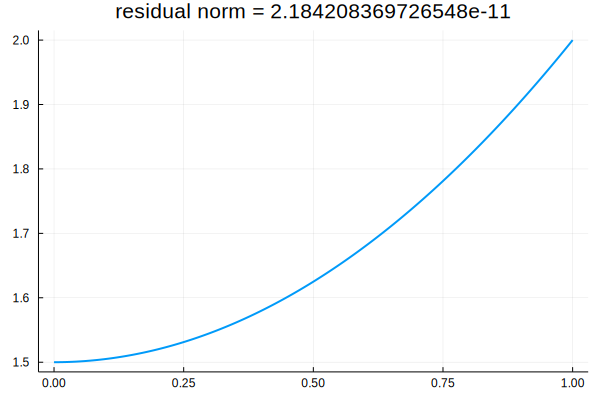

In [5]:
using NLsolve
sol = nlsolve(residual,jac,0*x)
using Plots
plot(x,sol.zero,title="residual norm = $(sol.residual_norm)")

<!-- While the numerical method is "discretize-then-linearize," to obtain expressions for the Jacobian it's often easier to linearize first, then discretize. Suppose that we want to linearize the operator $f(u)=u''+uu'+1$ around the function $u=U(x)$. If we perturb $u$ to $U+ \epsilon v(x)$, then 

$$
f(U+\epsilon v) & = (U+\epsilon v)'' + (U+\epsilon v)(U'+\epsilon v') - 1 \\ 
&= U'' + \epsilon v'' + U U' + \epsilon (Uv'+U'v) + O(\epsilon^2) - 1 \\ 
&= f(U) +\epsilon (v'' + Uv' + U'v) + O(\epsilon^2). 
$$

The $O(\epsilon)$ term represents the action of the "Jacobian" on the perturbation. That is,

$$
J(v) = v'' + Uv' + U'v. 
$$

(Note that the result, like any derivative, depends on the evaluation "point" $U$.) Hence, the "Jacobian operator" is

$$
J = \partial_{xx} + U \partial_x + U'. 
$$

The boundary conditions imply that $U+\epsilon v$ is zero at both ends, but since $U$ is, then $v$ must be as well. We would proceed by discretizing $J$ as a *linear* ODE, subject to homogeneous Dirichlet conditions. Things get trickier with Neumann and mixed boundary conditions, particularly if fictitious points are used, but with enough gumption, you can follow it through. -->

### Automatic differentiation

As you know, differentiation, unlike antidifferentiation, is a purely mechanical process following simple rules. In AD, these rules are applied numerically, not symbolically. For example, consider the function $\cos(x^2)$, to be evaluated at $x=3$. The first step for the computer is to square 3 to get 9. At the same time, we know the derivative of the result is $2\cdot 3=6$. Next, $\cos(9)$ is evaluated to get the value result, while we use the chain rule and also multiply 6 by $-\sin(9)$ to get the numerical derivative. The same ideas work multidimensionally, for all the mathematical functions we are likely to evaluate.

AD has taken off in popularity due to ML, where it is essential for training neural networks. There are many software tools for it, and when it works it can be fantastic. However, in the BVP context it can consume a lot of computing time as the number of unknowns grows, and most implementations can't yet cope with every kind of statement you want to use in evaluating the BVP operator.

### Finite differences

*Yo dawg, I gave you some finite differences with your finite differences.*

The difference

$$
\frac{\bff(\bfu + \epsilon \bfv) - \bff(\bfu)}{\epsilon}
$$

approximates the directional derivative $\bfJ(\bfu)\bfv$. The full Jacobian matrix can be recovered by applying this difference repeatedly in each of the coordinate axes directions. When there are $N$ unknowns, this process requires at least $O(N^2)$ work, but in principle that should be insignificant next to the $O(N^3)$ work needed to solve the linear system with $\bfJ$. 

The advantage of an FD Jacobian is that is requires only that $\bff$ be available, which is necessary for the entire problem. Because of this, it's usually the default choice.

However, it can be slow in practice, and it can be affected by roundoff error; we can expect an optimal accuracy that is only $O(\sqrt{\epsilon_\text{mach}})$. That could be improved by using a central difference for the directional derivative, but doing so requires twice as many evaluations of $\bff$, which is usually considered prohibitive. The drawbacks are mitigated somewhat in a quasi-Newton algorithm that tries to update the Jacobian at each nonlinear iteration, rather than computing it from scratch each time.

## Continuation

Here's an example known as the **Allen-Cahn equation**.

$$
\lambda u'' + u - u^3 = -\sin(5x), \quad u(0)=-1, \quad u(1)=1. 
$$

At $\lambda=0.08$, this equation gives us no trouble.

In [6]:
n = 200
a,b = 0,1
λ = 0.08

h = (b-a)/n
x = [a+i*h for i in 0:n]
Dx,Dxx = diffmats(x)
ode = u -> λ*Dxx*u + u - u.^3 + sin.(5x)
residual(u) =[ode(u)[2:n];u[1]+1;u[n+1]-1]
@elapsed sol1 = nlsolve(residual,zeros(n+1))

0.300625167

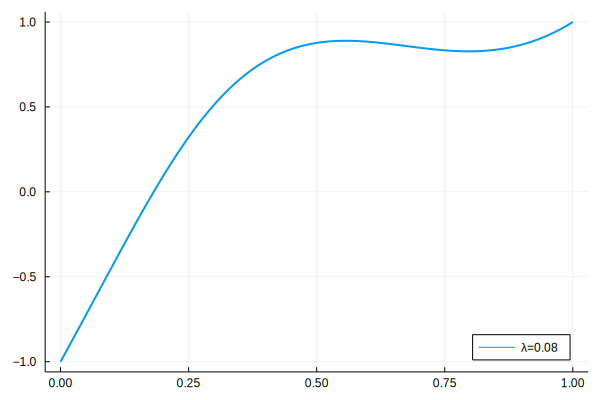

In [7]:
plot(x,sol1.zero,label="λ=0.08",leg=:bottomright)

However, when we decrease $\lambda$ just a bit, the solution takes *much* longer and looks very different.

In [8]:
λ = 0.07
@elapsed sol2 = nlsolve(residual,zeros(n+1))

5.030836167

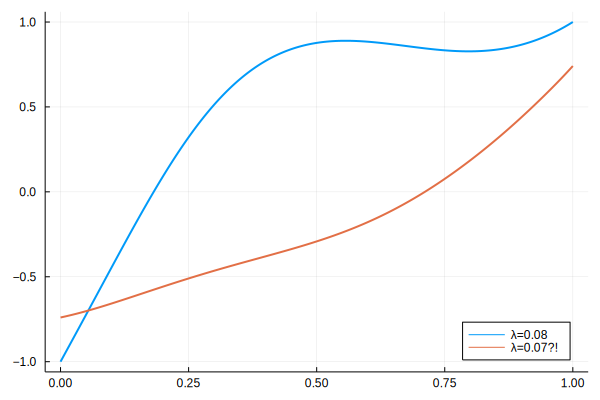

In [9]:
plot!(x,sol2.zero,label="λ=0.07?!")

A closer look at the nonlinear solver results shows that the iteration did not converge in the second case:

In [10]:
(sol1.residual_norm,sol2.residual_norm)

(6.95784541093758e-11, 0.606195234491817)

A simple way to fight back is **continuation**, in which we use the solution at a more tractable version of the problem as the initial estimate for the tougher problem.

In [11]:
@elapsed sol2 = nlsolve(residual,sol1.zero)

0.037668291

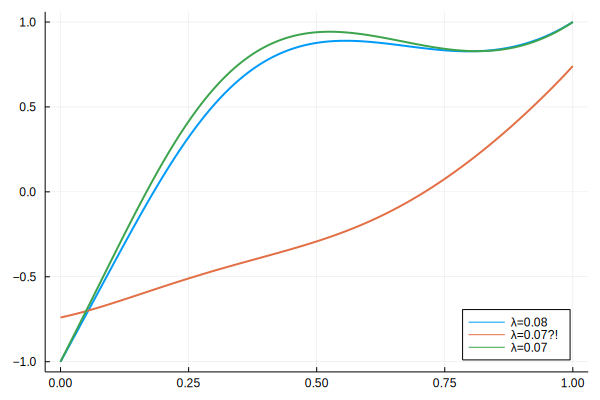

In [12]:
plot!(x,sol2.zero,label="λ=0.07")